# Initialize Environment

In [149]:
from dotenv import load_dotenv
load_dotenv()

True

In [150]:
import numpy as np
import pandas as pd
# ensure kaggle api credentials available via .env
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import shutil
import plotnine as p9
import scipy.special as ssp

In [151]:
DATA_NEEDS_DOWNLOADED = False

# Extract Data

In [152]:
if DATA_NEEDS_DOWNLOADED:

    # expected workflow, though authentication issues persist
    # api = KaggleApi()
    # api.authenticate()
    # api.competition_download_file(
    #   "dont-get-kicked", "training.csv", path="./data/dont_get_kicked"
    # )

    os.system('kaggle competitions download -c DontGetKicked')
    shutil.unpack_archive("DontGetKicked.zip", "./data")
    os.remove("DontGetKicked.zip")

In [153]:
df_train = pd.read_csv("./data/training.csv")
df_test = pd.read_csv("./data/test.csv")

In [154]:
print(df_train.shape)
print(df_test.shape)

(72983, 34)
(48707, 33)


In [155]:
df_train.head().transpose()

,0,1,2,3,4
RefId,1,2,3,4,5
IsBadBuy,0,0,0,0,0
PurchDate,12/7/2009,12/7/2009,12/7/2009,12/7/2009,12/7/2009
Auction,ADESA,ADESA,ADESA,ADESA,ADESA
VehYear,2006,2004,2005,2004,2005
VehicleAge,3,5,4,5,4
Make,MAZDA,DODGE,DODGE,DODGE,FORD
Model,MAZDA3,1500 RAM PICKUP 2WD,STRATUS V6,NEON,FOCUS
Trim,i,ST,SXT,SXT,ZX3
SubModel,4D SEDAN I,QUAD CAB 4.7L SLT,4D SEDAN SXT FFV,4D SEDAN,2D COUPE ZX3


# Analyze

## Build Intuition through Visual

In [156]:
print(df_train['VehOdo'].isnull().sum())
print(df_test['VehOdo'].isnull().sum())

0
0


In [157]:
x_q = df_train['VehOdo']
n_q = df_train.shape[0]

x_p = df_test['VehOdo']
n_p = df_test.shape[0]

In [158]:
N_BINS = 10

In [159]:
q = np.histogram(x_q, bins=N_BINS)
q

(array([   22,   145,   919,  5050, 10124, 16298, 22200, 15243,  2807,
          175]),
 array([  4825. ,  15914.2,  27003.4,  38092.6,  49181.8,  60271. ,
         71360.2,  82449.4,  93538.6, 104627.8, 115717. ]))

In [160]:
def format_histogram_bin_labels(hist_output):
    """Formatting tailored for magnitudes in 10,000s, 100,000s."""
    
    bin_edges = hist_output[1]
    labels = [
        str(i) + ": " + "[" + f"{bin_edges[i]:,.0f}" + ", " + 
        f"{bin_edges[i+1]:,.0f}" + ")" 
        for i in range(bin_edges.shape[0]-1)
        ]
    # last bin closed on both sides
    labels[-1] = labels[-1].replace(")", "]")
    
    return labels


In [161]:
bin_labels = format_histogram_bin_labels(q)

In [162]:
bin_labels

['0: [4,825, 15,914)',
 '1: [15,914, 27,003)',
 '2: [27,003, 38,093)',
 '3: [38,093, 49,182)',
 '4: [49,182, 60,271)',
 '5: [60,271, 71,360)',
 '6: [71,360, 82,449)',
 '7: [82,449, 93,539)',
 '8: [93,539, 104,628)',
 '9: [104,628, 115,717]']

In [163]:
df_q = pd.DataFrame({
    'n': q[0],
    'prb': q[0] / n_q,
    'series': 'Historical'
})
df_q['bin'] = bin_labels

In [164]:
p = np.histogram(x_p, bins=q[1])

In [165]:
p

(array([   29,   121,   672,  3203,  6433, 11176, 14937, 10334,  1672,
          126]),
 array([  4825. ,  15914.2,  27003.4,  38092.6,  49181.8,  60271. ,
         71360.2,  82449.4,  93538.6, 104627.8, 115717. ]))

In [166]:
df_p = pd.DataFrame({
    'n': p[0],
    'prb': p[0] / n_p,
    'series': 'Test'
})
df_p['bin'] = bin_labels

In [167]:
compare_p_q = pd.concat([df_q, df_p], axis=0)

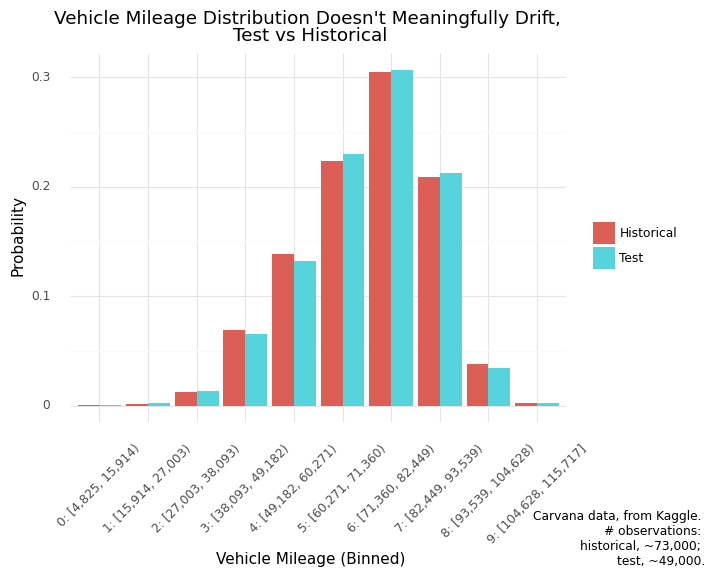

<ggplot: (8793576370932)>

In [168]:
(
    p9.ggplot(compare_p_q) + 
    p9.theme_minimal() + 
    p9.geom_col(p9.aes('bin', 'prb', fill='series'), position='dodge') + 
    p9.labs(y = "Probability", x = "Vehicle Mileage (Binned)", fill='',
            title=(
                "Vehicle Mileage Distribution Doesn't Meaningfully Drift, \n" +
                "Test vs Historical"
            ),
            caption = (
                "Carvana data, from Kaggle. \n" + 
                "# observations: \nhistorical, ~73,000; \ntest, ~49,000."
            )) + 
    p9.theme(
        axis_text_x=p9.element_text(angle=45), 
        plot_caption=p9.element_text(margin={'r': -100, 't': 25}),
        )
)

## Statistical Tests

In [169]:
kl_div_point = ssp.rel_entr(p[0] / n_p, q[0] / n_q).sum()
kl_div_point

0.0007486716020464318

In [170]:
def bootstrap_draw_kl_divergence(x_q, n_bins, nobs_test_set):
    """
    Under the (null) condition that 
    a new observations test set generates from 
    the baseline population probability distribution q:
    bootstrap sample one test set draw, then compute KL Divergence.

    q is unknown and estimable:
        - Has generated observations `x_q`
        - Estimated by discrete pmf with `n_bins`
    """

    q_hist = np.histogram(x_q, bins=n_bins)
    n_q = q_hist[0].sum()

    x_p_sample = np.random.choice(x_q, size=nobs_test_set, replace=True)
    p_hist = np.histogram(x_p_sample, bins=q_hist[1])

    q_hat = q_hist[0] / n_q
    p_hat = p_hist[0] / nobs_test_set

    kl_div = ssp.rel_entr(p_hat, q_hat).sum()

    out = {
        'p': p_hat, 'n_p': nobs_test_set, 'q': q_hat, 'kl_divergence': kl_div
        }

    return out

In [171]:
N_SAMPLING_DISTR_DRAWS = 1000

In [172]:
def bootstrap_sampling_distr_kl_divergence(x_q, n_bins, nobs_test_set, n_draws):
    """
    Under the (null) condition that 
    a new observations test set generates from 
    the baseline population probability distribution q:
    simulate sampling distribution of KL Divergence value.

    q is unknown and estimable:
        - Has generated observations `x_q`
        - Estimated by discrete pmf with `n_bins`

    When a new observations test set does truly generate from
    population probability distribution q, 
    KL Divergence sampling variation partly controlled by:
        - Test set sample size (small sample size, wider variation)
        - Probability distribution q estimate precision 
        (more discretized bins, wider variation) 

    """

    kl_div_draws = [
        bootstrap_draw_kl_divergence(x_q, n_bins, nobs_test_set)
        for i in range(n_draws)
    ]

    kl_div_values = [x['kl_divergence'] for x in kl_div_draws]
    idx_sort = np.argsort(kl_div_values)
    kl_div_draws = [kl_div_draws[i] for i in idx_sort]

    return kl_div_draws


### Naive

In [173]:
kl_div_distr0 = bootstrap_sampling_distr_kl_divergence(
    x_q, N_BINS, df_test.shape[0], N_SAMPLING_DISTR_DRAWS
    )
kl_div_distr = [x['kl_divergence'] for x in kl_div_distr0]

In [174]:
sum(np.array(kl_div_distr) > kl_div_point)

0

In [175]:
np.quantile(kl_div_distr, q = [0.1, 0.25, 0.5, 0.75, 0.9])

array([4.16145348e-05, 6.19209340e-05, 8.81352118e-05, 1.20881794e-04,
       1.55518143e-04])

In [176]:
# delta = [kl_div_distr[i] - kl_div_distr[i-1] for i in range(1, len(kl_div_distr))]
# sum(np.array(delta) < 0)

### Calibrated

In [184]:
kl_div_distr0 = bootstrap_sampling_distr_kl_divergence(
    x_q, N_BINS, 100, N_SAMPLING_DISTR_DRAWS
    )
kl_div_distr = [x['kl_divergence'] for x in kl_div_distr0]

sum(np.array(kl_div_distr) > kl_div_point)

1000

In [185]:
df_p = pd.DataFrame({
    'prb': kl_div_distr0[999]['p'], 'series': 'Test Draw from Historical'
    })
df_p['bin'] = df_p.index.values

df_q = pd.DataFrame({'prb': kl_div_distr0[999]['q'], 'series': 'Historical'})
df_q['bin'] = df_q.index.values

compare_p_q = pd.concat([df_p, df_q], axis=0)

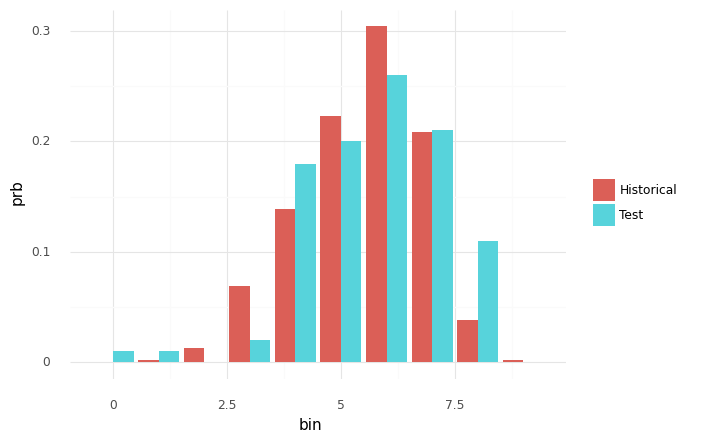

<ggplot: (8793576238288)>

In [186]:
(
    p9.ggplot(compare_p_q) + 
    p9.theme_minimal() + 
    p9.geom_col(p9.aes('bin', 'prb', fill='series'), position='dodge') + 
    p9.labs(title = "", fill='')
)

In [180]:
kl_div_distr0 = bootstrap_sampling_distr_kl_divergence(
    x_q, N_BINS, 1000, N_SAMPLING_DISTR_DRAWS
    )
kl_div_distr = [x['kl_divergence'] for x in kl_div_distr0]

sum(np.array(kl_div_distr) > kl_div_point)

999

In [181]:
df_p = pd.DataFrame({'prb': kl_div_distr0[999]['p'], 'series': 'Test'})
df_p['bin'] = df_p.index.values

df_q = pd.DataFrame({'prb': kl_div_distr0[999]['q'], 'series': 'Train'})
df_q['bin'] = df_q.index.values

compare_p_q = pd.concat([df_p, df_q], axis=0)

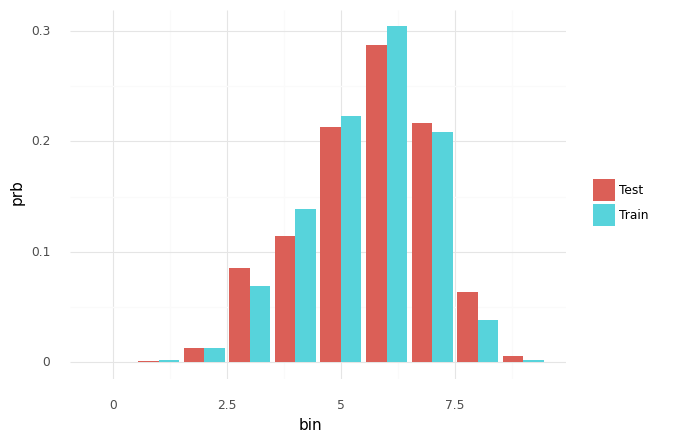

<ggplot: (8793576296400)>

In [182]:
(
    p9.ggplot(compare_p_q) + 
    p9.theme_minimal() + 
    p9.geom_col(p9.aes('bin', 'prb', fill='series'), position='dodge') + 
    p9.labs(fill='')
)

In [183]:
kl_div_distr0 = bootstrap_sampling_distr_kl_divergence(
    x_q, N_BINS, 10000, N_SAMPLING_DISTR_DRAWS
    )
kl_div_distr = [x['kl_divergence'] for x in kl_div_distr0]

sum(np.array(kl_div_distr) > kl_div_point)

108